# Sprint13課題 深層学習スクラッチ畳み込みニューラルネットワーク2



## 1.この課題の目的
- スクラッチを通してCNNの基礎を理解する
- 基本的なCNNのキーワードを学習する
- 初期の有名なCNNモデルを知る

## 2.スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装する。

Sprint12では1次元畳み込み層を実装したが、Sprint13では画像に対して一般的に使われる2次元畳み込み層を実装する。

また、プーリング層なども作成することで、CNNの基本形を完成させる。

### データセットの用意
引き続きMNISTデータセットを使用する。

2次元畳み込み層へは、28×28の状態で入力する。

今回は白黒画像であるからチャンネルは1つしかないが、チャンネル方向の軸は用意しておく必要がある。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にすること。

### CNN分類器クラスの作成
2次元畳み込みニューラルネットワークモデルのクラスScratch2dCNNClassifierを作成する。

In [1]:
# 数値演算
import numpy as np
import pandas as pd

# 描画
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習
from sklearn.model_selection import train_test_split

# データセット
from keras.datasets import mnist

Using TensorFlow backend.


### MNIST

In [2]:
# データの準備
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 正規化
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# データの分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### サンプルデータセット

In [0]:
# データのshape
N, C, H, W = 1,4,3,3 # インプット
FN, FC, FH, FW = 4,3,3,3 # フィルタ
PH, PW = 0, 0
SH, SW = 1, 1

# データセット
sample_input = np.random.randn(N * C * H * W).reshape(N, C, H, W)
sample_filter = np.ones(FN * FC * FH * FW).reshape(FN, FC, FH, FW)
sample_pad = np.array([PH, PW])
sample_stride = np.array([SH,SW])
sample_y = np.random.randint(30, 31, N*FN*16).reshape(N, FN, 4, 4)

## 【問題1】2次元畳み込み層の作成

Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成すること。

フォワードプロパゲーションの数式は以下のようになる。

<br>

<div style="text-align:center;">
    $a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}$
</div>

<br>

- $ai,j,m$ : 出力される配列のi行j列、mチャンネルの値

- $i$ : 配列の行方向のインデックス

- $j$ : 配列の列方向のインデックス

- $m$ : 出力チャンネルのインデックス

- $K$ : 入力チャンネル数

- $F_h,F_w$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

- $x(i+s),(j+t),k$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値

- $w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

- $b_m$ : mチャンネルへの出力のバイアス項

<br>

全てスカラーである。

<br>


- $w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}}$
- $b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}$

- $α$ : 学習率

- $\frac{∂L}{∂w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 L の勾配

- $\frac{∂L}{∂b_m}$ : $b_m$ に関する損失 L の勾配

<br>

勾配$ \frac{∂L}{∂w_{s,t,k,m}}$ や $\frac{∂L}{∂b_m}$ を求めるためのバックプロパゲーションの数式が以下である。

<br>

- $\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}$

- $\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}$

- $\frac{∂L}{∂ai}$ : 勾配の配列のi行j列、mチャンネルの値

- $N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

<br>

前の層に流す誤差の数式は以下である。

<br>

- $\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}$


- $\frac{∂L}{∂x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

- $M$ : 出力チャンネル数

<br>

但し、 $i−s<0$ または $i−s>N_{out,h}−1$ または $j−t<0$ または $j−t > N_{out,w}−1$ のとき$ \frac{∂L}{∂a_{(i−s),(j−t),m}}=0$ です。

In [0]:
import numpy as np

class Conv2d:
    """
    2次元畳み込み層のクラス
    
    Parameters
    ----------
    lr : float
        学習率
    
    F : 次の形のndarray, shape(m_samples,  n_channels, o_height, p_width)
        フィルタ
    
    P : 次の形のndarray, shape()
        パディング
    
    S : 次の形のndarray, shape()
        ストライド
    
    sigma : float
        標準偏差
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(m_samples, n_channels, o_height,  p_width)
        入力値
    
    """
    
    def __init__(self, lr, F, P, S, sigma=0.01):
        
        self.lr = lr
        
        # フィルタを4次元（FN, FC, FH, FW）にする
        if F.ndim == 1:
            F = F[np.newaxis, np.newaxis, np.newaxis, :]
        elif F.ndim == 2:
            F = F[np.newaxis, np.newaxis, :, :]
        elif F.ndim == 3:
            F = F[np.newaxis, :, :, :]
        
        self.F = F
        self.P = P
        self.S = S
        
        # 入力値
        self.N_in = None # サンプル数
        self.C_in = None # チャンネル数
        self.H_in = None # 高さ
        self.W_in = None # 横幅       
        
        # フィルタ
        self.FN = self.F.shape[0] # フィルタ数
        self.FC = self.F.shape[1] # カーネル数
        self.FH = self.F.shape[2] # カーネルの高さ
        self.FW = self.F.shape[3] # カーネルの横幅
        
        # バイアス
        self.sigma = sigma # 標準偏差
        self.B = self.sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        
        # パディング
        self.PH = self.P[0] # 高さ
        self.PW = self.P[1] # 横幅
                
        # ストライド
        self.SH = self.S[0] # 高さ
        self.SW = self.S[1] # 横幅
        
        # 出力値
        self.N_out = None # サンプル数
        self.C_out = None # チャンネル数
        self.H_out = None # 高さ
        self.W_out = None # 横幅
        
        # 微分
        self.dA = None # 後の層からの勾配
        self.dB = None # バイアス
        self.dF = None # フィルタ
        self.dZ = None # 前の層に流す勾配
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(sample, channel, height,  width)
            入力値
        
        Returns
        ----------
        N_out : 次の形のndarray, shape(sample, channel, height,  width)
            出力値
        
        """
        # （mnistなど）チャンネル情報が存在しない場合、入力値を4次元（N, C, H, W）にする
        if Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        self.Z = Z.copy()
        
        # 入力値
        self.N_in = Z.shape[0] # サンプル数
        self.C_in = Z.shape[1] # チャンネル数
        self.H_in = Z.shape[2] # 高さ
        self.W_in = Z.shape[3] # 横幅  
        
        # 出力値
        self.N_out = self.N_in # サンプル数（入力値の数に等しい）
        self.C_out = self.FN # チャネル数（フィルタの枚に等しい）
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        # 畳み込み演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # 畳み込み演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層からの勾配
        
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            前の層に流す誤差
        
        """
        self.dA = dA.copy()
        
        # バイアス
        self.dB = np.mean(dA, axis=(-2,-1))
        
        # 重み
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層への勾配
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各カーネルの勾配
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとフィルタのアダマール積をストライド毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in, self.W_in))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0) # 深さ方向にsum
        
        # 最後にチャネル毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
    
    
    def calc_OutputSize(self, ):
        """
        2次元畳み込み後の出力サイズ

        Parameters
        -----------
        I : 次の形のndarray, shape(sample, channel, height, width)
            入力のサイズ

        Returns
        ----------
        N_out : 次の形のndarray, shape(sample, chanel, height, width)
            入力のサイズ

        """
        
        # 出力サイズを計算する
        self.H_out = int((self.H_in + 2*self.PH - self.FH) / self.SH) + 1 # 高さ
        self.W_out = int((self.W_in + 2*self.PW - self.FW) / self.SW) + 1 # 幅

        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out

### 検証

In [0]:
clf = Conv2d(lr = 1e-2, F=sample_filter, P=sample_pad, S=sample_stride)
N_out = clf.forward(sample_input)
#N_out.shape
N_out

array([[[[-7.07342202]],

        [[-7.07342202]],

        [[-7.07342202]],

        [[-7.07342202]]]])

In [0]:
# 損失
dA = N_out - sample_y
dA.shape

(1, 4, 4, 4)

In [0]:
clf.backward(dA).shape

(1, 4, 3, 3)

## 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められる。
この計算を行う関数を作成すること。


- $N_{h,out} =  \frac{N_{h,in} + 2P_{h} - F_{h}}{S_{h}} + 1$

- $N_{w,out} =  \frac{N_{w,in} + 2P_{w} - F_{w}}{S_{w}} + 1$

- $N_{out}$ : 出力のサイズ（特徴量の数）

- $N_{in}$ : 入力のサイズ（特徴量の数）

- $P$ : ある方向へのパディングの数

- $F$ : フィルタのサイズ

- $S$ : ストライドのサイズ

- $h$ が高さ方向、 $w$ が幅方向である

In [0]:
def calc_OutputSize(input_data, P, F, S):
    """
    2次元畳み込み後の出力サイズ
    
    Parameters
    -----------
    I : 次の形のndarray, shape(m_samples, n_channels, o_heights, p_width)
        入力のサイズ
    
    P : 次の形のndarray, shape(height, width)
        パディング（1次元）
    
    F : 次の形のndarray, shape(m_samples, n_channels, o_heights, p_width)
        フィルタのサイズ
        
    S : 次の形のndarray, shape(height, width)
        ストライドのサイズ（1次元）
    
    Returns
    ----------
    N_out : 次の形のndarray, shape(m_samples, n_channels, o_heights, p_width)
        入力のサイズ
    
    """
    
    # 入力値を4次元（N, C, H, W）にする
    if input_data.ndim == 1:
        input_data = input_data[np.newaxis, np.newaxis, np.newaxis, :]
    elif input_data.ndim == 2:
        input_data = input_data[np.newaxis, np.newaxis, :, :]
    elif input_data.ndim == 3:
        input_data = input_data[np.newaxis, :, :, :]
    
    # フィルタを4次元（FN, FC, FH, FW）にする
    if F.ndim == 1:
        F = F[np.newaxis, np.newaxis, np.newaxis, :]
    elif F.ndim == 2:
        F = F[np.newaxis, np.newaxis, :, :]
    elif F.ndim == 3:
        F = F[np.newaxis, :, :, :]
    
    
    # 指標
    #print("input_data.shape : {}".format(input_data.shape))
    N_in = input_data.shape[0] # サンプル数
    C_in = input_data.shape[1] # チャンネル数
    H_in = input_data.shape[2] # 高さ
    W_in = input_data.shape[3] # 幅
    
    FN = F.shape[0] # フィルタ数
    FC = F.shape[1] # チャンネル数
    FH = F.shape[2] # 高さ
    FW = F.shape[3] # 幅
    
    PH = P[0] # 高さ
    PW = P[1] # 幅
    
    SH = S[0] # 高さ
    SW = S[1] # 幅
    
    # 出力サイズを計算する
    H_out = int((H_in + 2*PH - FH) / SH) + 1 # 高さ
    W_out = int((W_in + 2*PW - FW) / SW) + 1 # 幅
    
    # 出力値を初期化する
    N_out = np.zeros((N_in, FN , H_out, W_out)) # 初期化
    
    return N_out

In [0]:
N_out = calc_OutputSize(sample_input, sample_pad, sample_filter, sample_stride)
N_out.shape

(1, 4, 1, 1)

## 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成する。

プーリング層は数式で表さない方が分かりやすい部分もあるが、フォワードプロパゲーションの数式は以下のようになる。

<div style="text-align:center;">$a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}$</div>

- $P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 

- $S_h×S_w$ の範囲内の行（p）と列（q）

- $S_h,S_w$ : 高さ方向（h）と幅方向（w）のストライドのサイズ

- $(p,q)∈P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

- $a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値

- $x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになる。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要がある。（フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を代入する）


In [0]:
import numpy as np

class MaxPool2D:
    """
    最大プーリング層のクラス
    
    Parameters
    ----------
    stride : 次の形のndarray, shape(height, width)
        ストライド
    
    pad : 次の形のndarray, shape(height, width)
        パディング
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(samples, channels, height, width)
        入力値
    
    self.pool : 次の形のndarray, shape(samples, channels, height, width)
        プーリング層（各ストライドの最大値）
        
    self.pool : 次の形のndarray, shape(samples, channels, height * width)
        最大値のインデックスの行番号
        
    self.pool : 次の形のndarray, shape(samples, channels, height * width)
        最大値のインデックスの列番号
    
    """
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(m_samples, n_channels, o_height, p_width)
            入力値（活性化された畳み込み演算の出力値）
        
        Returns
        ----------
        Pooling_Layer : 次の形のndarray, shape()
            Maxプーリング層
        
        """
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        self.N, self.C, self.H, self.W = Z.shape
        
        # ストライド（高さ、幅）
        SH, SW = self.stride[0], self.stride[1]
        
        # ストライド数
        self.NH = int(self.H / SH) # 高さ方向に動く回数
        self.NW = int(self.W  / SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # プーリング
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # ストライド
                        self.pool[n][c][mh][mw] = np.amax(extract) # ストライドした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のインデックスを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool_row, self.pool_col
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        (フォワード時の最大値を持っていた箇所にそのままの誤差を流し、以外には0を入れる)
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層の勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            勾配
        
        """
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i]) # 勾配を流す要素の行番号
                    w = int(self.pool_col[n][c][i]) # 勾配を流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ

## 検証

In [0]:
N = 1
C = 1
H = 4
W = 4

sample = np.arange(N*C*H*W).reshape(N,C,H,W)
stride = np.array([2,2])

H = sample.shape[0]
W = sample.shape[1]
H_S = stride[0]
W_S = stride[1]

sample, stride

(array([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]]), array([2, 2]))

In [0]:
clf = MaxPool2D(stride=stride)
pool = clf.forward(sample)
clf.backward(sample)

array([[[[ 0.,  0.,  0.,  0.],
         [ 0.,  5.,  0.,  7.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 13.,  0., 15.]]]])

## 【問題4】平滑化
平滑化するためのクラスFlatten()を作成すること。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeする。

その値は記録しておき、バックワードのときに再びreshapeによって形を戻す。

In [0]:
import numpy as np

class Flatten:
    """
    平滑化を行うクラス
    
    Attributes
    ----------
    self.N : int
        サンプル数
    
    self.C : int
        チャンネル数
        
    self.H : int
        高さ
        
    self.W : int
        横幅
    
    """
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(m_samples, n_channels, o_height, p_width)
            入力値
        
        Returns
        ----------
        self.flat_Z : ndarray, shape(m_samples, o_height, p_width)
            平滑化後の入力値
        
        """
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # サンプル数
        self.C = Z.shape[1] # チャネル数
        self.H = Z.shape[2] # 高さ
        self.W = Z.shape[3] # 横幅
        
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros(self.N*self.C*self.H*self.W).reshape(self.N, self.C, self.H*self.W)
        
        for n in range(self.N):
            for c in range(self.C):
                self.flat_Z[n][c] = Z[n][c].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        -------------
        dA : 次の形のndarray, shape()
            後の層の勾配
        
        """
        
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA
        

### 検証

In [0]:
flatten = Flatten()
flat_forward = flatten.forward(sample)
flat_backward = flatten.backward(sample)

In [0]:
flat_forward.shape, flat_backward.shape

((1, 1, 16), (1, 1, 4, 4))

## 【問題5】学習・推定
作成したConv2dを使用してMNISTの分類を学習・推定する。

この段階では精度は気にせず、動くことを確認すること。

In [0]:
# 演算処理
import numpy as np

# 可視化
import matplotlib.pyplot as plt

# 機械学習
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

# プログレスバー
from tqdm import tqdm_notebook as tqdm

class Scratch2dCNNClassifier:
    """
    ディープニューラルネットワークのスクラッチ実装
    
    Parameters
    ----------
    activation : str
        活性化関数の種類
    
    batch_size : int
        ミニバッチのサイズ
    
    epoch : int
        エポック数
    
    initializer : str
        パラメータ初期値を生成するクラス
    
    lr : float
        学習率
        
    n_nodes1 : int
        １層目のレイヤー数
        
    n_nodes2 : int
        2層目のレイヤー数
    
    n_output : int
        出力数
    
    optimizer : str
        最適化手法
    
    random_state_batch : int
        ミニバッチ生成時の乱数のシード値
    
    random_state_para : int
        パラメータ初期値生成時の乱数のシード値
    
    sigma : float
        SimpleInitializerの標準偏差
    
    verbose : bool
        学習過程の出力
    
    Attributes
    ----------
    self.train_loss : list
        学習用データに基づく交差エントロピー損失
    
    self.val_loss : list
        検証用データに基づく交差エントロピー損失
    
    self.y_pred : 次の形のndarray, shape(m_samples)
        予測値
    """
    
    def __init__(self, activation="Tanh", batch=30, filter_info=(1,4,3,3), initializer="He", n_epochs=30, lr=1e-2, n_nodes1=400, n_nodes2=200, optimizer="AdaGrad", padding=0,  sigma=0.01, stride=1, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_features = 64
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        self.F = filter_info # フィルタの特徴量は１次元のNumpy配列（FN, FC, FH, FW）で与える。
        self.P = padding
        self.S = stride
        
        # パラメータ初期値
        if self.initializer == "Simple":
            initializer = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer = XavierInitializer()
        elif self.initializer == "He":
            initializer = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        
        # レイヤー（インスタンス生成）
        self.Conv = Conv2d(self.lr, self.F, self.P, self.S, self.sigma) # 畳み込み層
        self.Pool = MaxPool2D(self.S, self.P) # プーリング層
        self.Flat = Flatten() # 平滑化
        self.FC = FC(self.n_features, self.n_output, initializer, optimizer) # 全結合層
            
        # 活性化関数
        self.activation2 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
        
        
        # 損失
        self.train_loss = []
        self.val_loss = []
        
        # 予測値
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        学習
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape(m_samples, n_features)
            学習用データ（特徴量）
            
        y_train : 
            学習用データ（正解値）
            
        X_val : 
            検証用データ（特徴量）
            
        y_val : 次の形のndarray, shape(m_samples)
            検証用データ（正解値）
        
        """
        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X_train.ndim == 3:
            X_train = X_train[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if X_train.shape[1] != self.F[1]:
            print("Channels of X_train and filter should be same.")

        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        
        # 検証用データが存在する場合は、同様に前処理する
        if (X_val is not None) and  (y_val is not None):
            y_val = enc.fit_transform(y_val[:, np.newaxis])            
            if X_val.ndim == 3:
                X_val = X_val[:, np.newaxis, :, :]
            if X_val.shape[1] != self.F[1]:
                print("Channels of X_val and filter should be same.")
            
            
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
                
                # フォワードプロパゲーション
                A1 = self.Conv.forward(mini_X_train) # Conv (30, 1, 26, 26)
                Z1 = self.activation1.forward(A1) # ReLU
                Z2 = self.Pool.forward(Z1) # Pool
                Z3 = self.Flat.forward(Z2) # Flatten
                A2 = self.FC.forward(Z3) # Affine
                Z4 = self.activation2.forward(A2) # SoftMax
        
                # バックワードプロパゲーション
                dA2, train_loss = self.activation2.backward(Z4, mini_y_train)
                dZ3 = self.FC.backward(dA2)
                dZ2 = self.Flat.backward(dZ3)
                dZ1 = self.Pool.backward(dZ2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv.backward(dA1)
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
                # 検証用データを用いる場合、損失を計算する
                if (X_val is not None) and (y_val is not None):
                    A1_val = self.Conv.forward(X_val) # Conv (30, 1, 26, 26)
                    Z1_val = self.activation1.forward(A1_val) # ReLU
                    Z2_val = self.Pool.forward(Z1_val) # Pool
                    Z3_val = self.Flat.forward(Z2_val) # FlattenI 
                    A2_val = self.FC.forward(Z3_val) # Affine
                    Z4_val = self.activation2.forward(A2_val) # SoftMax

                    _, val_loss = self.activation2.backward(Z4_val, y_val) # 損失を計算

                    # 損失を格納
                    self.val_loss.append(val_loss)

                    # 学習過程を表示
                    if self.verbose == True:
                        print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        """
        予測
        
        Parameters
        ----------
        X : 次の形のndarray, shape(sample, channel, height, width)
            テストデータ
        
        Returns
        ----------
        y_pred : 次の形のndarray, shape(m_samples, )
            予測
        """
        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X.ndim == 3:
            X = X[:, np.newaxis, :, :]
        
        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if X.shape[1] != self.F[1]:
            print("Channels of X and filter should be same.")
        
        
        # フォワードプロパゲーション
        A1 = self.Conv.forward(X) # Conv
        Z1 = self.activation1.forward(A1) # ReLU
        Z2 = self.Pool.forward(Z1) # Pool
        Z3 = self.Flat.forward(Z2) # Flatten
        A2 = self.FC.forward(Z3) # Affine
        Z4 = self.activation2.forward(A2) # SoftMax
        
        # 確率が最大のインデックスを返す
        y_pred = np.argmax(Z4, axis=1)
        
        self.y_pred = y_pred
        
        return y_pred


    def show_learning_curve(self,):
        """
        学習曲線を描画する
        
        """
        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if len(val_loss) != 0:
            plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y):
        """
        予測の正解率をheatmapで可視化する関数
        
        Parameters
        -------------
        y : 次の形のndarray, shape(m_samples)
            正解ラベル
        
        """
        
        # カウント
        true_false  = np.zeros(100).reshape(10,10)

        # 正解ラベル、予測値の正誤表を作成
        for i in range(len(y)):
            true = y[i]
            pred = self.y_pred[i]

            true_false[true][pred] += 1

        # パーセンテージ換算
        true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

        # 可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_false, annot=True, cmap="GnBu")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.title("Accuracy of predicts.")
        plt.show()        
        

"""
ミニバッチを生成するクラス
"""
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (sample, channel, height, width)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


"""
以下、全結合層クラス
"""

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    
    Paramters
    ----------
    n_nodes1 : int
        前の層のノード数
        
    n_nodes2 : int
        後の層のノード数
    
    initializer : パラメータ初期値のインスタンス("SimpleInitializer", "Xavier", "He")
    
    optimizer : 最適化手法のインスタンス（"SGD" or "AdaGrad"）
    
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, n_nodes1)
            入力
        
        
        Returns
        ----------
        A : 次の形のndarray, shape(batch_size, n_nodes2)
            出力
            
        """
        self.forward_Z = Z.copy()
        
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dB : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ

    
"""""""""""""""""""""""""""""""""
以下、最適化手法のクラス
"""""""""""""""""""""""""""""""""

class SGD:
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : 学習率
    
    
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス(FC)
        
        
        Returns
        ----------
        layer : 更新後の層のインスタンス(FC)
        
        """
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    """
    AdaGradによる最適化
    
    Parameters
    ----------
    lr : float
        学習率
    
    Attributes
    ----------
    self.H : 次の形のndarray, shape()
        重みに関する勾配の二乗和
    
    self.K : 次の形のndarray, shape()
        バイアスに関する勾配の二乗和
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        
        """
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)
        
        self.H_W = self.H_W + dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    


"""""""""""""""""""""""""""""
以下、活性化関数クラス
"""""""""""""""""""""""""""""
class Sigmoid:
    """
    シグモイド関数
    
    
    """
    def __init__(self, ):
        
        self.forward_A = None
    
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape()
            入力
        
        """
        self.forward_A = A
        
        self.Z = 1 / (1 + np.exp(-A))
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        dA : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dZ * (1 - self.Z) * self.Z
    
    

class Tanh:
    """
    ハイパボリックタンジェント関数
    
    Parameters
    ----------
    
    """
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape()
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.tanh(A)
        
        return self.Z

    
    def backward(self, dA):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        dA : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dA * (1 - self.Z**2)


class ReLU:
    """
    ReLU関数
    
    """
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape()
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    """
    ソフトマックス関数
    
    """
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape()
        
        Returns
        ----------
        Z3 : 次の形のndarray, shape(m_samples, n_features)
            予測確率
        
        """
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z3 = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z3
    
    
    def backward(self, Z3, Y):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        Z3 : 次の形のndarray, shape
            予測確率（＝第３層におけるフォワードプロパゲーション）
        
        Y : 次の形のndarray, shape(m_samples, )
            正解値
        
        Returns
        ----------
        dA : 次の形ndarray
            勾配
        
        loss : float
            交差エントロピー誤差
            
        """
        
        dA = Z3 - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z3 + 1e-7)) / Y.shape[0]
        
        return dA, loss
    
    
"""""""""""""""""""""""""""""""""""""""
以下、パラメータ初期化クラス
"""""""""""""""""""""""""""""""""""""""
    
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B


"""
以下、CNN関連のクラス
"""
    
class Conv2d:
    """
    2次元畳み込み層のクラス
    
    Parameters
    ----------
    lr : float
        学習率
    
    F : 次の形のndarray, shape(m_samples,  n_channels, height, width)
        フィルタ
    
    P : 次の形のndarray, shape()
        パディング
    
    S : 次の形のndarray, shape()
        ストライド
    
    sigma : float
        標準偏差
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(m_samples, n_channels, o_height,  p_width)
        入力値
    
    """
    
    def __init__(self, lr, F, P, S, sigma):
        
        self.lr = lr
        
        # 入力値
        self.N_in = None # サンプル数
        self.C_in = None # チャンネル数
        self.H_in = None # 高さ
        self.W_in = None # 横幅       
        
        # フィルタ
        self.FN = F[0] # フィルタ数
        self.FC = F[1] # カーネル数
        self.FH = F[2] # カーネルの高さ
        self.FW = F[3] # カーネルの横幅
        self.F = np.random.randn(self.FN, self.FC, self.FH, self.FW)
        
        # バイアス
        self.B = sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        
        # パディング
        self.PH = P # 高さ
        self.PW = P # 横幅
                
        # ストライド
        self.SH = S # 高さ
        self.SW = S # 横幅
        
        # 出力値
        self.N_out = None # サンプル数
        self.C_out = None # チャンネル数
        self.H_out = None # 高さ
        self.W_out = None # 横幅
        
        # 微分
        self.dA = None # 後の層からの勾配
        self.dB = None # バイアス
        self.dF = None # フィルタ
        self.dZ = None # 前の層に流す勾配
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(sample, channel, height,  width)
            入力値
        
        Returns
        ----------
        N_out : 次の形のndarray, shaper(sample, channesl, height, width)
            畳み込み後の出力
        
        """
 
        self.Z = Z.copy()

        # 入力値
        self.N_in = Z.shape[0] # サンプル数
        self.C_in = Z.shape[1] # チャンネル数
        self.H_in = Z.shape[2] # 高さ
        self.W_in = Z.shape[3] # 横幅  
        
        # 出力値
        self.N_out = self.N_in # サンプル数（入力値の数に等しい）
        self.C_out = self.FN # チャネル数（フィルタの枚に等しい）
        
        # パディング
        Z = np.pad(Z, [(0,0),(0,0),(self.PH, self.PH),(self.PW, self.PW)], mode="constant")
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        
        # 畳み込み演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # 畳み込み演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層からの勾配
        
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            前の層に流す誤差
        
        """
        self.dA = dA.copy()
        
        # バイアス
        self.dB = np.sum(dA, axis=(-2,-1))
        
        # 重み
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層への勾配
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各カーネルの勾配
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとフィルタのアダマール積をストライド毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in+(self.PH*2), self.W_in+(self.PW*2)))
        
        # 逆方向の畳み込みを行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0)[self.PH:-self.PH, self.PW:-self.PW] # 深さ方向にsum
        
        # 最後にチャネル毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
    
    
    def calc_OutputSize(self, ):
        """
        2次元畳み込み後の出力サイズ

        Parameters
        -----------
        I : 次の形のndarray, shape(samples, channels, height, width)
            入力のサイズ

        Returns
        ----------
        N_out : 次の形のndarray, shape(sample, chanel, heights, width)
            入力のサイズ

        """
        
        # 出力サイズを計算する
        self.H_out = int(((self.H_in + 2*self.PH - self.FH) / self.SH) + 1) # 高さ
        self.W_out = int(((self.W_in + 2*self.PW - self.FW) / self.SW) + 1) # 幅
        
        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out
    


class MaxPool2D:
    """
    最大プーリング層のクラス
    
    Parameters
    ----------
    stride : 次の形のndarray, shape(height, width)
        ストライド
    
    pad : 次の形のndarray, shape(height, width)
        パディング
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(sample, channel, height, width)
        入力値
    
    self.pool : 次の形のndarray, shape(sample, channel, height, width)
        プーリング層（各ストライドの最大値）
        
    self.pool : 次の形のndarray, shape(sample, channel, height * width)
        最大値のインデックスの行番号
        
    self.pool : 次の形のndarray, shape(sample, channel, height * width)
        最大値のインデックスの列番号
    
    """
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
        self.SH, self.SW = stride, stride
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(sample, channel, height, width)
            入力値（活性化された畳み込み演算の出力値）
        
        Returns
        ----------
        self.pool : 次の形のndarray, shape(sample, channel, height, width)
            Maxプーリングによる出力
        
        """
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        self.N, self.C, self.H, self.W = Z.shape
        
        # ストライド（高さ、幅）
        SH, SW = self.stride, self.stride
        
        # ストライド数
        self.NH = int(self.H / SH) # 高さ方向に動く回数
        self.NW = int(self.W  / SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # プーリング
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # ストライド
                        self.pool[n][c][mh][mw] = np.amax(extract) # ストライドした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のインデックスを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        (フォワード時の最大値を持っていた箇所にそのままの誤差を流し、それ以外には0を入れる)
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層の勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            勾配
        
        """
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i] / self.SH)# 勾配を流す要素の行番号
                    w = int(self.pool_col[n][c][i] / self.SW) # 勾配を流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ
    

class Flatten:
    """
    平滑化を行うクラス
    
    Attributes
    ----------
    self.N : int
        サンプル数
    
    self.C : int
        チャンネル数
        
    self.H : int
        高さ
        
    self.W : int
        横幅
    
    """
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(samples, channels, height, width)
            入力値
        
        Returns
        ----------
        self.flat_Z : ndarray, shape(sample, height, width)
            平滑化後の入力値
        
        """        
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # サンプル数
        self.C = Z.shape[1] # チャネル数
        self.H = Z.shape[2] # 高さ
        self.W = Z.shape[3] # 横幅
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros((self.N, self.C*self.H*self.W))
        
        for n in range(self.N):
            self.flat_Z[n] = Z[n].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        -------------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層の勾配
        
        """
        
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA

### CNNの検証

In [0]:
f = np.array([1,1,3,3]) # フィルタ（１枚、１チャンネル、高さ：３、横幅：３）

clf  = Scratch2dCNNClassifier(batch=512, filter_info=f, lr=1e-1, n_epochs=1, verbose=False, padding=3, stride=2)

In [0]:
clf.fit(X_train, y_train, X_val, y_val)

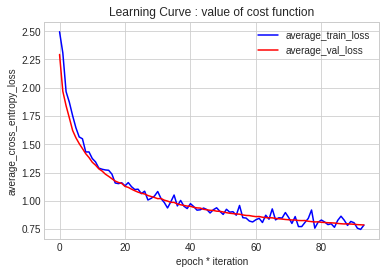

In [0]:
clf.show_learning_curve()

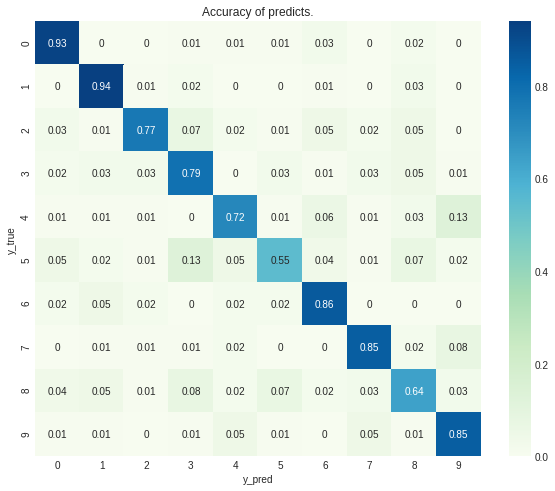

In [0]:
y_pred = clf.predict(X_test)
clf.show_accuracy(y_test)

- エポック数が少なく精度については改善の余地があるものの、モデルが正常に動作することは確認できた。

## 【問題6】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的。

現在では実用的に使われることはないが、歴史的に重要なのは1998年のLeNetである。

この構造を再現して動かしてみること。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

※上記論文から引用

サブサンプリングとは現在のプーリングに相当するものである。

活性化関数も当時はシグモイド関数だが、現代風にReLUとし、以下のように作成すること。


- 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数


In [0]:
# 演算処理
import numpy as np

# 可視化
import matplotlib.pyplot as plt

# 機械学習
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

# プログレスバー
from tqdm import tqdm_notebook as tqdm

class LeNet:
    """
    LeNetのスクラッチ実装
    
    Parameters
    ----------
    activation : str
        活性化関数の種類
    
    batch_size : int
        ミニバッチのサイズ
    
    epoch : int
        エポック数
    
    initializer : str
        パラメータ初期値を生成するクラス
    
    lr : float
        学習率
        
    n_nodes1 : int
        １層目のレイヤー数
        
    n_nodes2 : int
        2層目のレイヤー数
    
    n_output : int
        出力数
    
    optimizer : str
        最適化手法
    
    random_state_batch : int
        ミニバッチ生成時の乱数のシード値
    
    random_state_para : int
        パラメータ初期値生成時の乱数のシード値
    
    sigma : float
        SimpleInitializerの標準偏差
    
    verbose : bool
        学習過程の出力
    
    Attributes
    ----------
    self.train_loss : list
        学習用データに基づく交差エントロピー損失
    
    self.val_loss : list
        検証用データに基づく交差エントロピー損失
    
    self.y_pred : 次の形のndarray, shape(m_samples)
        予測値
    """
    
    def __init__(self, activation="ReLU", batch=30, filter_info=np.array([[6,1,5,5],[16,1,5,5]]), initializer="He", n_epochs=30, lr=1e-2, n_nodes1=120, n_nodes2=84, optimizer="AdaGrad", padding=0,  sigma=0.01, stride=1, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.n_features = 6400
        self.n_nodes1 = 120
        self.n_nodes2 = 84
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        # 畳み込み
        
        # フィルタの特徴量は１次元（FN, FC, FH, FW）のNumpy配列で与える。
        self.F1 = filter_info[0]
        self.F2 = filter_info[1]
        """
        if filter_info.ndim == 1:
            self.F = filter_info[np.newaxis, np.newaxis, np.newaxis, :]
        elif filter_info.ndim == 2:
            self.F = filter_info[np.newaxis, np.newaxis, :, :]
        elif filter_info.ndim == 3:
            self.F = filter_info[np.newaxis, :, :, :]
        """
        
        #print("self.F : {}".format(filter_info.ndim))
        
        self.P = padding
        self.S = stride
        
        # パラメータ初期値
        if self.initializer == "Simple":
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
        elif self.initializer == "He":
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
        
        # 活性化関数
        self.activation5 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
            self.activation2 = Sigmoid()
            self.activation3 = Sigmoid()
            self.activation4 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
            self.activation3 = Tanh()
            self.activation4 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()
            self.activation3 = ReLU()
            self.activation4 = ReLU()
        
        
        # レイヤー（インスタンス生成）
        self.Conv1 = Conv2d(self.lr, self.F1, self.P, self.S, self.sigma) # 畳み込み（出力チャンネル６）
        self.Conv2 = Conv2d(self.lr, self.F2, self.P, self.S, self.sigma) # 畳み込み（出力チャンネル１６）
        self.Pool1 = MaxPool2D(self.S, self.P) # プーリング層
        self.Pool2 = MaxPool2D(self.S, self.P) # プーリング層
        self.Flat = Flatten() # 平滑化
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1) # 全結合層
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2) # 全結合層
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3) # 全結合層
        
        # 損失
        self.train_loss = []
        self.val_loss = []
        
        # 予測値
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        学習
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape(m_samples, n_features)
            学習用データ（特徴量）
            
        y_train : 
            学習用データ（正解値）
            
        X_val : 
            検証用データ（特徴量）
            
        y_val : 次の形のndarray, shape(m_samples)
            検証用データ（正解値）
        
        """
        
        # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X_train.ndim == 3:
            X_train = X_train[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if (X_train.shape[1] != self.F1[1]) or (X_train.shape[1] != self.F2[1]):
            print("Channels of X_train and filter should be same.")
            

        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        
        # 検証用データが存在する場合は、同様に前処理する
        if (X_val is not None) and  (y_val is not None):
            y_val = enc.fit_transform(y_val[:, np.newaxis])            
            if X_val.ndim == 3:
                X_val = X_val[:, np.newaxis, :, :]
            if X_val.shape[1] != self.F1[1]:
                print("Channels of X_val and filter should be same.")
                
            
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in tqdm(get_mini_batch):
                
                # フォワードプロパゲーション
                A1 = self.Conv1.forward(mini_X_train) # Conv 
                Z1 = self.activation1.forward(A1) # ReLU
                Z2 = self.Pool1.forward(Z1) # Pool
                A2 = self.Conv2.forward(Z2) # Conv
                Z3 = self.activation2.forward(A2) # ReLU
                Z4 = self.Pool2.forward(Z3) # Pool
                Z5 = self.Flat.forward(Z4) # Flatten
                A3 = self.FC1.forward(Z5) # Affine
                Z6 = self.activation3.forward(A3) # ReLU
                A4 = self.FC2.forward(Z6) # Affine
                Z7 = self.activation4.forward(A4) # ReLU
                A5 = self.FC3.forward(Z7) # Affine
                Z8 = self.activation5.forward(A5) # SoftMax
                
                
                # バックワードプロパゲーション
                dA5, train_loss = self.activation5.backward(Z8, mini_y_train)
                dZ7 = self.FC3.backward(dA5)
                dA4 = self.activation4.backward(dZ7)
                dZ6 = self.FC2.backward(dA4)
                dA3 = self.activation3.backward(dZ6)
                dZ5 = self.FC1.backward(dA3)
                dZ4 = self.Flat.backward(dZ5)
                dZ3 = self.Pool2.backward(dZ4)
                dA2 = self.activation2.backward(dZ3)
                dZ2 = self.Conv2.backward(dA2)
                dZ1 = self.Pool1.backward(dZ2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv1.backward(dA1)
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
            # 検証用データを用いる場合、損失を計算する
            if (X_val is not None) and (y_val is not None):
                get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size = self.batch, seed = 0)
                for mini_X_val, mini_y_val in get_mini_batch_val:
                    A1_val = self.Conv1.forward(mini_X_val) # Conv 
                    Z1_val = self.activation1.forward(A1_val) # ReLU
                    Z2_val = self.Pool1.forward(Z1_val) # Pool
                    A2_val = self.Conv2.forward(Z2_val) # Conv
                    Z3_val = self.activation2.forward(A2_val) # ReLU
                    Z4_val = self.Pool2.forward(Z3_val) # Pool
                    Z5_val = self.Flat.forward(Z4_val) # Flatten
                    A3_val = self.FC1.forward(Z5_val) # Affine
                    Z6_val = self.activation3.forward(A3_val) # ReLU
                    A4_val = self.FC2.forward(Z6_val) # Affine
                    Z7_val = self.activation4.forward(A4_val) # ReLU
                    A5_val = self.FC3.forward(Z7_val) # Affine
                    Z8_val = self.activation5.forward(A5_val) # SoftMax
                    
                    _, val_loss = self.activation5.backward(Z8_val, mini_y_val) # 損失を計算

                    # 損失を格納
                    self.val_loss.append(val_loss)

                # 学習過程を表示
                if self.verbose == True:
                    print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        """
        予測
        
        Parameters
        ----------
        X : 次の形のndarray, shape(m_samples, n_features)
            テストデータ    
            
        Returns
        ----------
        y_pred : 次の形のndarray, shape(m_samples, )
            予測
            
        """
       # 特徴量にチャンネルの次元がない場合、チャンネルの軸を追加する
        if X.ndim == 3:
            X = X[:, np.newaxis, :, :]

        # 入力データのチャンネル数とフィルタのチャンネル数の一致を確認する
        if (X.shape[1] != self.F1[1]) or (X.shape[1] != self.F2[1]):
            print("Channels of X_train and filter should be same.")
        
        # フォワードプロパゲーション
        A1 = self.Conv1.forward(X) # Conv 
        Z1 = self.activation1.forward(A1) # ReLU
        Z2 = self.Pool1.forward(Z1) # Pool
        A2 = self.Conv2.forward(Z2) # Conv
        Z3 = self.activation2.forward(A2) # ReLU
        Z4 = self.Pool2.forward(Z3) # Pool
        Z5 = self.Flat.forward(Z4) # Flatten
        A3 = self.FC1.forward(Z5) # Affine
        Z6 = self.activation3.forward(A3) # ReLU
        A4 = self.FC2.forward(Z6) # Affine
        Z7 = self.activation4.forward(A4) # ReLU
        A5 = self.FC3.forward(Z7) # Affine
        Z8 = self.activation5.forward(A5) # SoftMax
        
        # 確率が最大のインデックスを返す
        y_pred = np.argmax(Z8, axis=1)
        
        self.y_pred = y_pred
        
        return y_pred


    def show_learning_curve(self,):
        """
        学習曲線を描画する
        
        """
        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        if val_loss is not None:
          plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y):
        """
        予測の正解率をheatmapで可視化する関数
        
        Parameters
        -------------
        y : 次の形のndarray, shape(m_samples)
            正解ラベル
        
        """
        
        # カウント
        true_false  = np.zeros(100).reshape(10,10)

        # 正解ラベル、予測値の正誤表を作成
        for i in range(len(y)):
            true = y[i]
            pred = self.y_pred[i]

            true_false[true][pred] += 1

        # パーセンテージ換算
        true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

        # 可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_false, annot=True, cmap="GnBu")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.title("Accuracy of predicts.")
        plt.show()        
        

"""
ミニバッチを生成するクラス
"""
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


"""
以下、全結合層クラス
"""

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    
    Paramters
    ----------
    n_nodes1 : int
        前の層のノード数
        
    n_nodes2 : int
        後の層のノード数
    
    initializer : パラメータ初期値のインスタンス("SimpleInitializer", "Xavier", "He")
    
    optimizer : 最適化手法のインスタンス（"SGD" or "AdaGrad"）
    
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, n_nodes1)
            入力
        
        
        Returns
        ----------
        A : 次の形のndarray, shape(batch_size, n_nodes2)
            出力
            
        """
        self.forward_Z = Z.copy()
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dB : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ

    
"""""""""""""""""""""""""""""""""
以下、最適化手法のクラス
"""""""""""""""""""""""""""""""""

class SGD:
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : 学習率
    
    
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス(FC)
        
        
        Returns
        ----------
        layer : 更新後の層のインスタンス(FC)
        
        """
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    """
    AdaGradによる最適化
    
    Parameters
    ----------
    lr : float
        学習率
    
    Attributes
    ----------
    self.H : 次の形のndarray, shape()
        重みに関する勾配の二乗和
    
    self.K : 次の形のndarray, shape()
        バイアスに関する勾配の二乗和
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        
        """
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)

        self.H_W += dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    


"""""""""""""""""""""""""""""
以下、活性化関数クラス
"""""""""""""""""""""""""""""

class ReLU:
    """
    ReLU関数
    
    """
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape()
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    """
    ソフトマックス関数
    
    """
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape()
        
        Returns
        ----------
        Z3 : 次の形のndarray, shape(m_samples, n_features)
            予測確率
        
        """
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z3 = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z3
    
    
    def backward(self, Z3, Y):
        """
        バックワードプロパゲーション（微分）
        
        Parameters
        ----------
        Z3 : 次の形のndarray, shape
            予測確率（＝第３層におけるフォワードプロパゲーション）
        
        Y : 次の形のndarray, shape(m_samples, )
            正解値
        
        Returns
        ----------
        dA : 次の形ndarray
            勾配
        
        loss : float
            交差エントロピー誤差
            
        """
        
        dA = Z3 - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z3 + 1e-7)) / Y.shape[0]
        
        
        return dA, loss
    
    
"""""""""""""""""""""""""""""""""""""""
以下、パラメータ初期化クラス
"""""""""""""""""""""""""""""""""""""""
    
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B


"""
以下、CNN関連のクラス
"""
    
class Conv2d:
    """
    2次元畳み込み層のクラス
    
    Parameters
    ----------
    lr : float
        学習率
    
    F : 次の形のndarray, shape(m_samples,  n_channels, height, width)
        フィルタ
    
    P : 次の形のndarray, shape()
        パディング
    
    S : 次の形のndarray, shape()
        ストライド
    
    sigma : float
        標準偏差
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(m_samples, n_channels, o_height,  p_width)
        入力値
    
    """
    
    def __init__(self, lr, F, P, S, sigma):
        
        self.lr = lr
        
        # 入力値
        self.N_in = None # サンプル数
        self.C_in = None # チャンネル数
        self.H_in = None # 高さ
        self.W_in = None # 横幅       
        
        # フィルタ
        self.FN = F[0] # フィルタ数
        self.FC = F[1] # カーネル数
        self.FH = F[2] # カーネルの高さ
        self.FW = F[3] # カーネルの横幅
        self.F = np.random.randn(self.FN, self.FC, self.FH, self.FW)
        
        # バイアス
        #self.B = sigma * np.random.randn(self.FC).reshape(self.FC, 1, 1)
        self.B = sigma * np.random.randn(self.FC, 1, 1)
        
        # パディング
        self.PH = P # 高さ
        self.PW = P # 横幅
                
        # ストライド
        self.SH = S # 高さ
        self.SW = S # 横幅
        
        # 出力値
        self.N_out = None # サンプル数
        self.C_out = None # チャンネル数
        self.H_out = None # 高さ
        self.W_out = None # 横幅
        
        # 微分
        self.dA = None # 後の層からの勾配
        self.dB = None # バイアス
        self.dF = None # フィルタ
        self.dZ = None # 前の層に流す勾配
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(m_samples, n_channels, o_height,  p_width)
            入力値
        
        Attributes
        ----------
        
        
        """
        """
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        """        
        self.Z = Z.copy()
        
        # 入力値
        self.N_in = Z.shape[0] # サンプル数
        self.C_in = Z.shape[1] # チャンネル数
        self.H_in = Z.shape[2] # 高さ
        self.W_in = Z.shape[3] # 横幅  
        
        # 出力値
        self.N_out = self.N_in # サンプル数（入力値の数に等しい）
        self.C_out = self.FN # チャネル数（フィルタの枚に等しい）
        
        # パディング
        Z = np.pad(Z, [(0,0),(0,0),(self.PH, self.PH),(self.PW, self.PW)], mode="constant")
        
        # 出力をゼロで初期化（shape：N_in, FN, OH, OW）
        N_out = self.calc_OutputSize()
        
        
        # 畳み込み演算用の配列を生成する（channel, H, W）
        conv = np.zeros((self.FC, self.H_out,  self.W_out))
        
        # 畳み込まれる入力値を格納する配列（N_out, FN, FC, H_out*W_out, FH * FW）
        self.conv_z = np.zeros((self.N_out, self.FN, self.FC, self.H_out*self.W_out, self.FH*self.FW))
        
        # 畳み込み演算を行う
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    count = 0
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            self.conv_z[n_out][fn][fc][count] = Z[n_out][fc][self.SH*h : self.FH + self.SH*h, self.SW*w : self.FW + self.SW*w].flatten()
                            count += 1
                    # フィルタリングした入力値とフィルタのアダマール積を取り、バイアスを加算する
                    adam = self.conv_z[n_out][fn][fc] * self.F[fn][fc].flatten()
                    conv[fc] = np.sum(adam, axis=1).reshape(self.H_out, self.W_out)
                # convをチャネル方向にsumして、置換する
                conv += self.B
                conv_sum = np.sum(conv, axis=0)

                N_out[n_out][fn] = conv_sum

        return N_out
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層からの勾配
        
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            前の層に流す誤差
        
        """
        self.dA = dA.copy()
        
        # バイアス
        self.dB = np.sum(dA, axis=(-2,-1))
        
        # 重み
        self.dF = np.zeros((self.FN, self.FC, self.FH, self.FW))
        conv = np.zeros((self.H_out * self.W_out, self.FH * self.FW))
                    
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for i in range(self.H_out*self.W_out):                        
                        conv[i] = dA[n_out][fn].flatten()[i] * self.conv_z[n_out][fn][fc][i]
                    self.dF[fn][fc] = np.sum(conv, axis=0).reshape(self.FH, self.FW)
                    

        # 前の層への勾配
        self.dZ = np.zeros((self.N_in , self.C_in , self.H_in , self.W_in))
        
        # 各カーネルの勾配
        dZ_conv = np.zeros((self.N_in, self.FN * self.FC, self.H_in, self.W_in))
        
        # dAとフィルタのアダマール積をストライド毎に格納する配列
        conv = np.zeros((self.H_out*self.W_out, self.H_in+(self.PH*2), self.W_in+(self.PW*2)))
        
        for n_out in range(self.N_out):
            for fn in range(self.FN):
                for fc in range(self.FC):
                    for h in range(self.H_out):
                        for w in range(self.W_out):
                            conv[h+w][self.SH*h : self.SH*h + self.FH, self.SW * w: self.SW*w + self.FW] = dA[n_out][fn].flatten()[i] * self.F[fn][fc]
                    dZ_conv[n_out][fn+fc] = np.sum(conv, axis=0)
        
        # 最後にチャネル毎に合計する
        for n in range(self.N_in):
            for c in range(self.C_in):
                for i in range(self.FN * self.FC):
                    if i % self.C_in == c:
                        self.dZ[n][c] += dZ_conv[n][i]
                                
        return self.dZ
        
    
    def calc_OutputSize(self, ):
        """
        2次元畳み込み後の出力サイズ

        Parameters
        -----------
        I : 次の形のndarray, shape(samples, channels, height, width)
            入力のサイズ

        Returns
        ----------
        N_out : 次の形のndarray, shape(samples, channels, height, width)
            入力のサイズ

        """
        
        # 出力サイズを計算する
        self.H_out = int(((self.H_in + 2*self.PH - self.FH) / self.SH) + 1) # 高さ
        self.W_out = int(((self.W_in + 2*self.PW - self.FW) / self.SW) + 1) # 幅
        
        # 出力値を初期化する
        N_out = np.zeros((self.N_out, self.C_out , self.H_out, self.W_out)) # 初期化
        
        return N_out
    


class MaxPool2D:
    """
    最大プーリング層のクラス
    
    Parameters
    ----------
    stride : 次の形のndarray, shape(height, width)
        ストライド
    
    pad : 次の形のndarray, shape(height, width)
        パディング
    
    Attributes
    ----------
    self.Z : 次の形のndarray, shape(samples, channels, height, width)
        入力値
    
    self.pool : 次の形のndarray, shape(samples, channels, height, width)
        プーリング層（各ストライドの最大値）
        
    self.pool : 次の形のndarray, shape(samples, channels, height * width)
        最大値のインデックスの行番号
        
    self.pool : 次の形のndarray, shape(samples, channels, height * width)
        最大値のインデックスの列番号
    
    """
    
    def __init__(self, stride=1, pad=0):
        
        self.stride = stride
        self.pad = pad
        
        self.pool = None
        self.pool_row = None
        self.pool_col = None
        
        self.Z = 0
        self.SH, self.SW = stride, stride
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(samples, channels, height, width)
            入力値（活性化された畳み込み演算の出力値）
        
        Returns
        ----------
        Pooling_Layer : 次の形のndarray, shape()
            Maxプーリング層
        
        """
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        self.N, self.C, self.H, self.W = Z.shape
        
        # ストライド（高さ、幅）
        SH, SW = self.stride, self.stride
        
        # ストライド数
        self.NH = int(self.H / SH) # 高さ方向に動く回数
        self.NW = int(self.W  / SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.pool_row = np.zeros((self.N, self.C, self.NH * self.NW))
        self.pool_col = np.zeros((self.N, self.C, self.NH * self.NW))
        
        
        # プーリング
        for n in range(self.N):
            for c in range(self.C):
                count = 0
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = Z[n][c][SH*mh : SH*(mh+1), SW*mw: SW*(mw+1)] # ストライド
                        self.pool[n][c][mh][mw] = np.amax(extract) # ストライドした範囲内で最大値をを見つける
                        index_max = np.unravel_index(np.argmax(extract), extract.shape) # 最大値のインデックスを取得
                        self.pool_row[n][c][count] = index_max[0] + SH*mh
                        self.pool_col[n][c][count] = index_max[1] + SW*mw
                        count += 1
        
        return self.pool
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        (フォワード時の最大値を持っていた箇所にそのままの誤差を流し、それ以外には0を入れる)
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(sample, channel, height, width)
            後の層の勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
            勾配
        
        """
        
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.NH * self.NW):
                    h = int(self.pool_row[n][c][i] / self.SH)# 勾配を流す要素の行番号
                    w = int(self.pool_col[n][c][i] / self.SW) # 勾配を流す要素の列番号
                    dZ[n][c][h:h+1,w:w+1] = dA[n][c][h:h+1,w:w+1]
        
        return dZ
    

class Flatten:
    """
    平滑化を行うクラス
    
    Attributes
    ----------
    self.N : int
        サンプル数
    
    self.C : int
        チャンネル数
        
    self.H : int
        高さ
        
    self.W : int
        横幅
    
    """
    
    def __init__(self, ):
        
        self.N = None
        self.C = None
        self.H = None
        self.W = None
        
        self.flat_Z = None
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(samples, channels, height, width)
            入力値
        
        Returns
        ----------
        self.flat_Z : ndarray, shape(m_samples, o_height, p_width)
            平滑化後の入力値
        
        """        
        # 入力値の形状をインスタンス変数に格納
        self.N = Z.shape[0] # サンプル数
        self.C = Z.shape[1] # チャネル数
        self.H = Z.shape[2] # 高さ
        self.W = Z.shape[3] # 横幅
        
        
        # 平滑化する値をゼロで初期化しておく
        self.flat_Z = np.zeros((self.N, self.C*self.H*self.W))
        
        for n in range(self.N):
            self.flat_Z[n] = Z[n].flatten()
        
        return self.flat_Z
    
    
    def backward(self, dA):
        """
        バックワードプロパゲーション
        
        Parameters
        -------------
        dA : 次の形のndarray, shape()
            後の層の勾配
        
        """
        
        dA  = dA.flatten().reshape(self.N, self.C, self.H, self.W)
        
        return dA

### LeNetの検証

- 全てのデータセットを用いると学習・推定に相当の時間を要することから、データセットの一部を用いることとする。

In [0]:
LN = LeNet(batch=48, lr=1e-2, n_epochs=3, verbose=False)

In [13]:
len(X_train)

48000

In [1]:
# 学習用データの10%を用いる
n = 4800

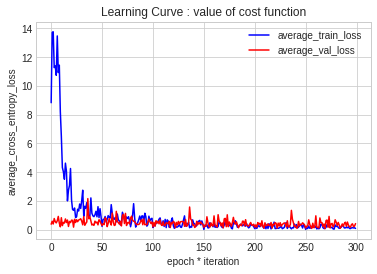

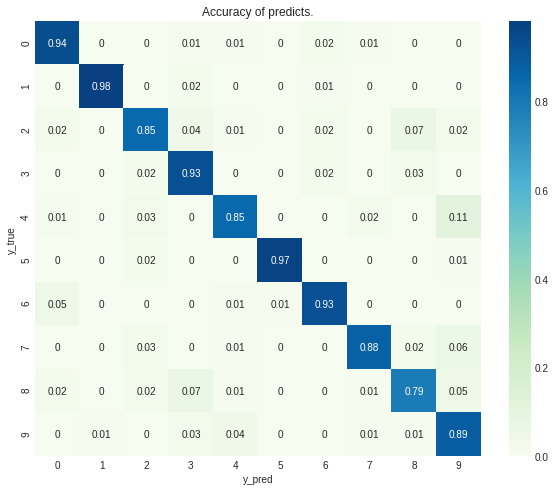

In [15]:
LN.fit(X_train[:n], y_train[:n], X_val[:n], y_val[:n])
LN.show_learning_curve()
y_pred = LN.predict(X_test[:1000])
LN.show_accuracy(y_test[:1000])

- LeNetを再現し、学習・推定が行われたことを確認した。

## 【問題7】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがある。

こういったものはフレームワークで既に用意されていることも多い。

どういったものがあるか簡単に調べてまとめること。

<参考>

[Applications - Keras Documentation](https://keras.io/ja/applications/)



<font color="blue">**1. AlexNet**</font>
    
    - 論文著者であるAlex Krizhevsky氏の名前を冠したモデル。
    - ImageNet LSVRC-2010コンテストの120万の高解像度画像を1000の異なるクラスに分類するために、Deep Neural Networkを訓練したもの。
    - ネットワークのアーキテクチャ
      - 6,000万個のパラメータと650,000個のニューロンを持つニューラルネットワークは、5つの畳み込み層から構成され、そのうちのいくつかには最大プーリング層が続いている。
      - そして、最後に1000方向のソフトマックスを持つ3つの完全接続層が続く。


<font color="blue">**2. VGG16, VGG19**</font>

    - Keras APIでは、ImageNetで事前学習したモデルを利用可能。（VGG16は16層から、VGG19は19層で構成される）
    - ImageNetとは何か？
        - WordNet階層に従って整理された画像データセットである。
        - WordNet階層の個々の概念（≒クラス）は、複数の単語または単語の句で記述される。（これらは "synonym set" もしくは "synset"と呼ばれる） 
        - WordNetには100,000以上のsynsetがあり、それらの大部分は名詞である。
        - ImageNetでは、各synsetを説明するために平均1000枚の画像を提供することを目指している。
        - それぞれの概念のイメージは、人の手で注釈が付けられ、品質が管理されている。


<font color="blue">**3. DenseNet**</font>

    - Keras APIでは、ImageNetで事前学習したDenseNetモデルを利用可能。
    - ネットワークのアーキテクチャは以下の通り。
       1. Convolution Layer : output_size(112 × 112), 7 × 7 conv, stride2
       2. Pooling Layer : output_size(56 × 56), 3 × 3 max pool, stride2
       3. Dense Layer : output_size(56 × 56), (1×1 conv or 3 × 3 conv) × 6 
       4. Transition Layer : output_size (56 × 56 with "1 × 1conv" or 28 × 28 with "2×2 average pool stride2")
       5. Dense Layer : output_size(28 × 28),  (1×1 conv or 3 × 3 conv) × 12
       6. Transition Layer : output_size (28 × 28 with "1 × 1conv" or 14 × 14 with "2×2 average pool stride2")
       7. Dense Layer : output_size(14 × 14),  (1×1 conv or 3 × 3 conv) × (24 ~ 64)
       8. Transition Layer : output_size (14 × 14 with "1 × 1conv" or 7 × 7 with "2×2 average pool stride2")
       9. Dense Layer : output_size(7 × 7),  (1×1 conv or 3 × 3 conv) × (16 ~ 48)
       10. Classification Layer : output_size(1×1), 7 × 7 global average pool, 1000D fully-connected softmax


<font color="blue">**4. ResNet50**</font>
    
    - VGG netsに着想を得たモデルで、34の層から構成される（大半が3×3の畳み込み層であり、strideは2）。論文では"Plain Network"と表現されている。
    - Plain Networkに、shortcut connectionを追加したResidual Networkも構築されている。
        - shortcut connectionとは、あるconvolutional層の出力を２つ先の畳み込み層の出力に加算するもの。これは畳み込みを行う際に特徴量を補填する（＝残していく）もので、residualの所以となっている。
    -  ネットワークのアーキテクチャーは以下の通り。
        - 7 × 7 conv (Layer1) : output_size (112　×　112)
        - Max pooling
        - 3 × 3 conv (Layer2 ~ Layer7) : output_size (56　×　56)
        - 3 × 3 conv (Layer8 ~ Layer15) : output_size (28　×　28)
        - 3 × 3 conv (Layer16 ~ Layer27) : output_size (14　×　14)
        - 3 × 3 conv (Layer28 ~ Layer33) : output_size (7　×　7)
        - global average pooling
        - 1000-way fully-connected Layer with softmax (Layer34)


<font color="blue">**5. MobileNet**</font>

    - Google Inc.が2017年に提唱したモデル。
    - Keras APIでは、ImageNetで事前学習したMobileNetモデルを利用可能。
    - Depthwise Separable Convolutionを取り入れた点が特徴であり、深さ方向に分離可能な畳み込みに基づいている。
        1. Standard convolution：深さ方向に畳み込む
        2. pointwise convolution：1×1の畳み込み

## 【問題8】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成すること。

- 範囲内の最大値ではなく、平均値を出力とするプーリング層である。

-  画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われない。



In [0]:
import numpy as np

class AveragePool2D:
    """
    平均プーリング層のクラス
    
    Parameters
    ----------
    F : 次の形のndarray, shape(sample, channel, height, width)
        フィルタ
    
    PH, PW : int
        パディング（height, width）
    
    SH, SW : int
        ストライド（height, width）
    
    """
    
    def __init__(self, F=[2,2], P=[0,0], S=[2,2]):
        
        self.FH, self.FW = F[0], F[1]
        self.P = P
        self.SH, self.SW = S[0], S[1]
        
        self.pool = None
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        -----------
        Z : 次の形のndarray, shape(sample, channel, height, width)
            入力値
        
        Returns
        ----------
        self.pool : 次の形のndarray, shape(sample, channel, height_forward_stride, width_forward_stride)
          出力値
        
        """
        
        # 入力値を4次元（N, C, H, W）にする
        if Z.ndim == 1:
            Z = Z[np.newaxis, np.newaxis, np.newaxis, :]
        elif Z.ndim == 2:
            Z = Z[np.newaxis, np.newaxis, :, :]
        elif Z.ndim == 3:
            Z = Z[np.newaxis, :, :, :]
        
        # 入力値（サンプル、チャンネル、高さ、横幅）
        N, C, H, W = Z.shape
        
        # パディング後の入力値
        X = np.zeros((N, C, H+self.P[0]*2, W+self.P[1]*2))
        
        for n in range(N):
          for c in range(C):
            X[n][c] = np.pad(Z[n][c], pad_width=self.P, mode="constant")
        
        # 入力値の形状を保存
        self.N, self.C, self.H, self.W = X.shape
        
        # ストライド数
        self.NH = int(self.H / self.SH) # 高さ方向に動く回数
        self.NW = int(self.W  / self.SW) # 横幅方向に動く回数
        
        # プーリング層を初期化
        self.pool = np.zeros((self.N, self.C, self.NH, self.NW))
        self.index = np.zeros((self.N, self.C, self.NH))
        
        
        # 平均プーリング
        for n in range(self.N):
            for c in range(self.C):
                for mh in range(self.NH):
                    for mw in range(self.NW):
                        extract = X[n][c][self.FH*mh : self.FH*(mh+1), self.FW*mw: self.FW*(mw+1)] # 畳み込みする範囲を抽出
                        index_ave = np.where(X[n][c][self.FH*mh : self.FH*(mh+1), self.FW*mw: self.FW*(mw+1)]) # 畳み込んだ範囲のインデックスを取得
                        self.pool[n][c][mh][mw] = np.average(extract) # 抽出した範囲内で平均値を算出し、プーリング層の値を置換                      
        
        return self.pool
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        
        Parameters
        -----------
        dA : 次の形のndarray, shape(sample, channel, height_forward_stride, width_forward_stride)
           後の層からの勾配
        
        Returns
        ------------
        dZ : 次の形のndarray, shape(sample, channel, height, width)
          前の層に流す勾配
        
        """
        # 勾配の高さ、幅
        dAH, dAW = dA.shape[2], dA.shape[3]
        
        # 初期化
        dZ = np.zeros((self.N, self.C, self.H, self.W))
        
        for n in range(self.N):
          for c in range(self.C):
            for i in range(dAH):
              for j in range(dAW):
                dZ[n][c][i*self.FH : (i+1)*self.FH , j*self.FW : (j+1)*self.FW] = dA[n][c][i][j] * 1/(self.FH*self.FW)
        
        # フォワードプロパゲーション時の入力値と同範囲のみ抽出（＝パディングした範囲に流れた勾配を削除）
        dZ = dZ[: , : , self.P[0] : self.H - self.P[0], self.P[1] : self.W - self.P[1]]
        
        return dZ

### 検証

In [0]:
ave_pool2d = AveragePool2D(P=[2,2], S=[2,2])

In [0]:
sample = np.arange(32).reshape(1,2,4,4)
sample

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]]])

#### フォワードプロパゲーション

In [0]:
forward = ave_pool2d.forward(sample)
forward, forward.shape

(array([[[[ 0. ,  0. ,  0. ,  0. ],
          [ 0. ,  2.5,  4.5,  0. ],
          [ 0. , 10.5, 12.5,  0. ],
          [ 0. ,  0. ,  0. ,  0. ]],
 
         [[ 0. ,  0. ,  0. ,  0. ],
          [ 0. , 18.5, 20.5,  0. ],
          [ 0. , 26.5, 28.5,  0. ],
          [ 0. ,  0. ,  0. ,  0. ]]]]), (1, 2, 4, 4))

#### バックプロパゲーション

In [0]:
gradient = np.arange(forward.size).reshape(forward.shape)
gradient

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]]])

In [0]:
backward = ave_pool2d.backward(gradient)
backward, backward.shape

(array([[[[1.25, 1.25, 1.5 , 1.5 ],
          [1.25, 1.25, 1.5 , 1.5 ],
          [2.25, 2.25, 2.5 , 2.5 ],
          [2.25, 2.25, 2.5 , 2.5 ]],
 
         [[5.25, 5.25, 5.5 , 5.5 ],
          [5.25, 5.25, 5.5 , 5.5 ],
          [6.25, 6.25, 6.5 , 6.5 ],
          [6.25, 6.25, 6.5 , 6.5 ]]]]), (1, 2, 4, 4))

- フォワードプロパゲーション、バックプロパゲーション共に、正しく計算が行われていることを確認した。

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要がある。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になる。

フレームワークでは各層のパラメータ数を表示させることが可能だが、意味を理解していなくては適切な調整が行えない。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算すること。（パラメータ数についてはバイアス項も考える）

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算すること。端が欠けてしまうので、こういった設定は好ましくないという例。

### 計算結果
1. output_shape = (1, 6, 141, 141) # (samples, channels, height, width)
  - output_height = (144 + 2*0 - 3) + 1 = 141
  - output_width = (144 + 2*0 - 3) + 1 = 141


2. output_shape = (1, 48, 58, 58) # (samples, channels, height, width)
  - output_height = (60 + 2*0 - 3) + 1 = 58
  - output_width = (60 + 2*0 - 3) + 1 = 58


3.  output_shape = (1, 20, 9, 9) # (samples, channels, height, width) => 17〜19行目、17,〜19列目の畳み込みで終える計算。
  - output_height = ((20-1) + 2*0 - 3)/2 + 1 = 9
  - output_width = ((20-1) + 2*0 - 3)/2 + 1 = 9

## 【問題10】（アドバンス課題）フィルタサイズに関する調査

畳み込み層にはフィルタサイズというハイパーパラメータがあるが、2次元畳み込み層において現在では3×3と1×1の使用が大半である。

以下のそれぞれを調査し、自分なりに考えて説明すること。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

### 調査結果

1. 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
  - <font color="blue">理由</font>：以下の通り、小さなフィルタのほうが相対的に計算コストが低く、より複雑な特徴を捕捉することが可能だから。
  - <font color="blue">小さなフィルタサイズの特徴</font>
    - フィルタサイズが小さい（＝用いる重みの総数が少ない）ため、計算コストが低い。
      - 例：3×3のフィルタ、２層レイヤー（＝18個の重みを用いる）を通して、１枚の画像(224, 224, 1)のサイズを"4"だけ小さくする場合、計算回数は合計1,758,312回となる。
        - 1層目：887,112回 = 222(output_height) * 222(output_width) * 18(***9*** (weight * component) + ***8***  (add weighted components) + ***1*** (add bias))
        - 2層目：871,200回 = 220(output_height) * 220(output_width) * 118(***9*** (weight * component) + ***8***  (add weighted components) + ***1*** (add bias))
    - 多くの層を用いるため、複雑な特徴を抽出することが出来る。（非線形性が強い）
      - 層を深くすることは、すなわち、各層ごとに特徴量のスコープを分割して特徴抽出を行うことを意味する。
    
  - <font color="blue">大きなフィルタサイズの特徴</font>
    - フィルタサイズが大きい（＝用いる重みの総数が多い）ため、計算コストが高い。
      - 例：5×5のフィルタ、１層レイヤー（＝25個の重みを用いる）を通して、１枚の画像(224, 224, 1)のサイズを"4"だけ小さくする場合、計算回数は合計2,420,000回となる。
        - 1層目：2,420,000 = 220(output_height) * 220(output_width) * 50(***25*** (weight * component) + ***24***  (add weighted components) + ***1*** (add bias))
    - 層の数を少なくする必要があり、複雑な特徴抽出が難しい。


2. 高さや幅方向を持たない1×1のフィルタの効果
  - 効果：チャンネル方向に畳み込みを行うことにより、次元削減が行われ、畳み込みの計算量を抑えることができる。
    - 高さや幅方向を持たない1×1のフィルタによる畳み込みを<font color="blue">"pointwise convolution"</font>と言う。
    - 実際には、チャンネル方向の軸を持つフィルタを用いてチャンネル方向に畳み込みを行う。

### 参考情報

- [Deciding optimal kernel size for CNN](https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363)

### Take away

- 基本的なConvolutional Neural Networkの構造、及び動作について理解を深めることができた。

- 特に重要だと考える点は以下の通り。
  - 各レイヤーのユニット数を、入力値・出力値の形状と整合性させること。
  - 畳み込みによる出力値のサイズは、入力値のサイズに対して減少する。
    - 仮に各レイヤーのフィルタの枚数を一定とすると、ネットワークを深くする上での制約となる。
    - したがって、途中の畳み込み層のフィルタ枚数を増やすことにより、特徴量のサイズの減少を抑え、ネットワークを深くすることができる。
  - 目的に応じてフィルタのサイズを調整すること。
  
- ネットワークの深さに比例して、学習・推定に時間を要することに注意。